## test parcellation approach with subj05

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import h5py
import numpy as np
import scipy as sp
import scipy.stats as stats
import nibabel as nibabel
import pandas as pd
import nibabel.freesurfer.mghformat as mgh
import scipy.io
import itertools 
import pickle

In [2]:
import sys
utils_dir = '/oak/stanford/groups/kalanit/biac2/kgs/projects/Dawn/NSD/code/streams/utils/'
sys.path.append(utils_dir)

In [3]:
from rsm_utils import get_flat_lower_tri, make_flat_rsms

In [4]:
data_dir = '../../../data/'
local_data_dir = '../../../local_data/'

subjid = ['06']
n_repeats = 3

#threshold for voxels (based on split-half reliability)
thresh = 0 #0.1 #0.2

In [5]:
#get ROI data
rh_parcels = []
for sidx, sid in enumerate(subjid):
    mgh_file = mgh.load(local_data_dir+'freesurfer/subj'+ sid +'/rh.tessellate.mgz')
    rh_parcels.append(mgh_file.get_fdata()[:,0,0])

In [6]:
num_rois = int(np.max(rh_parcels))

In [7]:
#get voxel level split-half reliability data
reliability = []
for sidx, sid in enumerate(subjid):
    
    sh_dir = local_data_dir + 'freesurfer/subj' + sid + '/rh_split_half.mat'
    sh = scipy.io.loadmat(sh_dir)
    
    reliability.append(sh['mean'])

In [8]:
# let's organize by ROI 
sh_by_ROI = [[[] for j in range(num_rois)] for i in range(len(subjid))]
total_vox = np.zeros((len(subjid), num_rois))

for sidx, sid in enumerate(subjid):  
    for roi_idx in range(num_rois):       
        sh_by_ROI[sidx][roi_idx]=reliability[sidx][:,rh_parcels[sidx] == roi_idx+1]
        total_vox[sidx,roi_idx] = len(sh_by_ROI[sidx][roi_idx][0])

In [9]:
total_vox

array([[1087., 1072., 1094., 1173., 1114., 1269., 1300., 1571., 1165.,
        1707., 1560.,  920., 1333., 1540., 1220., 2202., 1956., 1700.,
        1015., 1000., 1429., 1866., 1798., 1366., 2811., 2253., 1223.,
        1575., 2135., 1893., 1373., 2092., 1446., 1723., 1674., 1860.,
        1525., 1229., 1396., 1383., 1664., 1607., 1052., 1367., 1879.,
        1198.]])

In [10]:
all_ids = []
max_session = np.zeros(len(subjid))
for sidx, sid in enumerate(subjid):
    
    data = pd.read_csv(data_dir+'nsddata/ppdata/subj'+ sid +'/behav/responses.tsv', sep='\t')
    
    max_session[sidx] = np.max(np.array(data['SESSION'])) 
    
    all_ids.append(np.array(data['73KID']))
    
    #shared_mask.append(np.isin(all_ids[sidx],sharedix))

In [11]:
which_reps = []
for sidx, sid in enumerate(subjid):
    vals, idx_start, count = np.unique(all_ids[sidx], return_counts=True,
                                    return_index=True)
    which_reps.append(vals[count == n_repeats])
    
least_trials = min(which_reps, key=len)

In [12]:
id_nums_3reps = []
mask_3reps = []
for sidx, sid in enumerate(subjid):
    
    data = pd.read_csv(data_dir+'nsddata/ppdata/subj'+ sid +'/behav/responses.tsv', sep='\t')
    
    mask_3reps.append(np.isin(all_ids[sidx],which_reps[sidx]))
    id_nums_3reps.append(np.array(data['73KID'])[mask_3reps[sidx]])


In [13]:
arr1inds = id_nums_3reps[sidx].argsort()

In [14]:
#right hemisphere
betas_by_ROI = [[] for j in range(num_rois)]

for sidx, sid in enumerate(subjid):
    
    print(sidx)
    mask = mask_3reps[sidx]
    sorted_betas = []
    
    #get all betas across all sessions
    for sess in range(1,int(max_session[sidx])+1):
        print(sess)
                
        if(sess < 10):
            idx = '0' + str(sess)
        else:
            idx = str(sess)

        raw_betas = h5py.File(local_data_dir+'freesurfer/subj'+sid+'/betas/rh.zscore_betas_session'+idx+'.hdf5','r')

        sess_betas = raw_betas['zscore_betas'][:][mask[(sess-1)*750:sess*750]]
        del raw_betas
        
        if(sess==1):
            for roi_idx in range(num_rois):
                betas_by_ROI[roi_idx] = sess_betas[:,rh_parcels[sidx] == roi_idx+1]
        else:
            for roi_idx in range(num_rois):
                betas_by_ROI[roi_idx] = np.append(betas_by_ROI[roi_idx],sess_betas[:,rh_parcels[sidx] == roi_idx+1],axis=0)
        
        del sess_betas


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [15]:
betas_by_repeat_by_ROI = [[[] for j in range(num_rois)] for i in range(len(subjid))]
for sidx, sid in enumerate(subjid):
    for roi_idx in range(num_rois):  
        
        sorted_betas = betas_by_ROI[roi_idx][arr1inds[::-1]]
        
        for r in range(n_repeats):
            betas_by_repeat_by_ROI[sidx][roi_idx].insert(r,sorted_betas[r::3])

In [16]:
betas_by_repeat_by_ROI[0][0]

[array([[ 0.03638571,  0.36289553,  0.01186645, ...,  0.51818448,
          0.85509564,  0.74439018],
        [-0.64568957, -0.51571564, -0.41998387, ...,  1.69984955,
          0.49925441,  0.18024916],
        [-0.05294327,  0.15706797, -0.12674174, ...,  0.60676433,
         -0.54648996, -0.98015703],
        ...,
        [-0.76905597, -0.8416574 , -0.92779242, ...,  1.21728167,
          1.46500736,  1.26830637],
        [-0.3746311 ,  0.04105045, -0.62293744, ..., -1.33257281,
         -1.06437689, -1.1392841 ],
        [-0.11769137, -0.75329656, -0.2344663 , ...,  0.04791451,
         -0.58871726, -0.69515216]]),
 array([[-0.3638883 , -0.1691601 , -0.10624174, ..., -1.97572936,
         -1.75434664, -1.66794426],
        [ 1.73242547,  2.12287895,  1.56499523, ..., -0.73398922,
          0.06202611,  0.34849453],
        [ 0.79970889,  0.46230832,  1.06871064, ...,  0.99131408,
          0.62241844,  0.55780935],
        ...,
        [ 0.58064305,  0.29807161,  0.59793167, ..., -

In [17]:
#Replace voxels with split-half reliability < thresh with NaNs and then trim those from data structure

#convert to nans
for sidx, sid in enumerate(subjid):  
    for roi_idx in range(num_rois): 
        for vox in range(len(sh_by_ROI[sidx][roi_idx][0])):
            if sh_by_ROI[sidx][roi_idx][0][vox] < thresh:
                betas_by_repeat_by_ROI[sidx][roi_idx][0][:,vox]=np.nan
                betas_by_repeat_by_ROI[sidx][roi_idx][1][:,vox]=np.nan
                betas_by_repeat_by_ROI[sidx][roi_idx][2][:,vox]=np.nan    
#trim out nans
for sidx, sid in enumerate(subjid):   
    for roi_idx in range(num_rois): 
        for r in range(n_repeats):
            temp = betas_by_repeat_by_ROI[sidx][roi_idx][r]
            trimmed = temp[:,~np.all(np.isnan(temp), axis=0)]

            betas_by_repeat_by_ROI[sidx][roi_idx][r] = trimmed

In [18]:
del sorted_betas

In [19]:
del betas_by_ROI

In [20]:
del trimmed

In [21]:
del temp

In [22]:
#Create RSMS for all the ROIs, repeats and subjects
tril_flat_shape = int((betas_by_repeat_by_ROI[0][0][0].shape[0]**2/2) - (betas_by_repeat_by_ROI[0][0][0].shape[0]/2))
flat_rsm_r1 = np.zeros((num_rois, tril_flat_shape))
flat_rsm_r2 = np.zeros((num_rois, tril_flat_shape))
flat_rsm_r3 = np.zeros((num_rois, tril_flat_shape))


In [23]:
sidx = 0
for roi_idx in range(num_rois):
        
    rsm = np.corrcoef(betas_by_repeat_by_ROI[sidx][roi_idx][0])
    flat_rsm_r1[roi_idx, :] = get_flat_lower_tri(rsm,diagonal=False)

    rsm = np.corrcoef(betas_by_repeat_by_ROI[sidx][roi_idx][1])
    flat_rsm_r2[roi_idx, :] = get_flat_lower_tri(rsm,diagonal=False)

    rsm = np.corrcoef(betas_by_repeat_by_ROI[sidx][roi_idx][2])
    flat_rsm_r3[roi_idx, :] = get_flat_lower_tri(rsm,diagonal=False)


In [24]:
flat_rsm_r1

array([[ 0.22163879, -0.22898952,  0.08036263, ...,  0.24869309,
         0.05151809, -0.02989942],
       [ 0.18168984, -0.59934564,  0.24561631, ...,  0.5073171 ,
        -0.27287274, -0.09570264],
       [ 0.13466941,  0.16283013, -0.00949118, ..., -0.04618625,
         0.47151934, -0.0297087 ],
       ...,
       [ 0.01052916,  0.02955036, -0.07184823, ...,  0.08113293,
         0.00238615, -0.15398958],
       [-0.05098402, -0.13393263,  0.13031135, ..., -0.11265067,
         0.05958221, -0.26555929],
       [-0.138768  ,  0.08249938, -0.04714741, ...,  0.12557533,
        -0.08300357, -0.27075331]])

In [25]:
r1_trial_order = [0, 0, 1, 1, 2, 2]
r2_trial_order = [1, 2, 0, 2, 0, 1]

In [26]:
del betas_by_repeat_by_ROI

In [27]:
del rsm

In [28]:
mega_matrix = np.zeros((num_rois,num_rois))

for roi_idx1 in range(num_rois): #rows - i.e. model candidate
    
    split_half = np.zeros((3))
    split_half = [stats.pearsonr(flat_rsm_r1[roi_idx1,:],flat_rsm_r2[roi_idx1,:])[0],
                  stats.pearsonr(flat_rsm_r1[roi_idx1,:],flat_rsm_r3[roi_idx1,:])[0],
                  stats.pearsonr(flat_rsm_r2[roi_idx1,:],flat_rsm_r3[roi_idx1,:])[0]]
    NC_model = np.mean(split_half) * 100
    
    for roi_idx2 in range(num_rois): #columns - i.e. target data
        
        split_half = np.zeros((3))
        split_half = [stats.pearsonr(flat_rsm_r1[roi_idx2,:],flat_rsm_r2[roi_idx2,:])[0],
                      stats.pearsonr(flat_rsm_r1[roi_idx2,:],flat_rsm_r3[roi_idx2,:])[0],
                      stats.pearsonr(flat_rsm_r2[roi_idx2,:],flat_rsm_r3[roi_idx2,:])[0]]
        NC_target = np.mean(split_half) * 100
        
        
        rsm_corr = np.zeros((6))
        
        rsm_corr[0] = stats.pearsonr(flat_rsm_r1[roi_idx1,:],
                                     flat_rsm_r2[roi_idx2,:])[0]
        rsm_corr[1] = stats.pearsonr(flat_rsm_r1[roi_idx1,:],
                                     flat_rsm_r3[roi_idx2,:])[0]
        rsm_corr[2] = stats.pearsonr(flat_rsm_r2[roi_idx1,:],
                                     flat_rsm_r1[roi_idx2,:])[0]
        rsm_corr[3] = stats.pearsonr(flat_rsm_r2[roi_idx1,:],
                                     flat_rsm_r3[roi_idx2,:])[0]
        rsm_corr[4] = stats.pearsonr(flat_rsm_r3[roi_idx1,:],
                                     flat_rsm_r1[roi_idx2,:])[0]
        rsm_corr[5] = stats.pearsonr(flat_rsm_r3[roi_idx1,:],
                                     flat_rsm_r2[roi_idx2,:])[0]
        
        mega_matrix[roi_idx1,roi_idx2] = np.mean(rsm_corr) * np.sqrt(100/NC_model) * np.sqrt(100/NC_target)
        

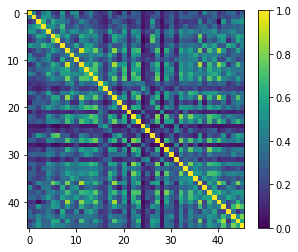

In [29]:
plt.imshow(mega_matrix)
plt.clim(0,1)
plt.colorbar(fraction=0.046, pad=0.04)

In [30]:
from sklearn.manifold import MDS
x, y = MDS(dissimilarity='precomputed').fit_transform(1-mega_matrix).T

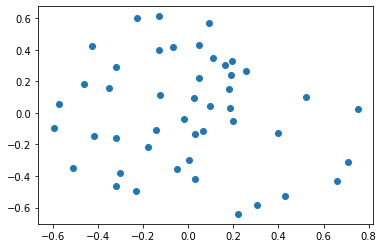

In [31]:
plt.scatter(x, y)

In [33]:
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from scipy.spatial.distance import squareform

In [34]:
sym_mm = np.around(mega_matrix, decimals = 5)

In [35]:
dists = squareform(1-sym_mm)

In [36]:
linkage_matrix = linkage(dists, "complete", optimal_ordering=True)


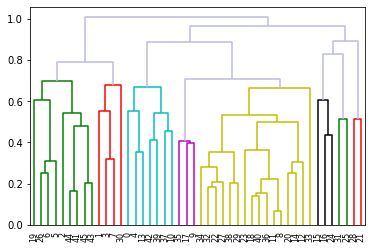

In [39]:
dn = dendrogram(linkage_matrix,
                above_threshold_color='#bcbddc')